In [1]:
import wget
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
import wget
url = 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv'
filename = wget.download(url)

In [3]:
url = 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv'
filename = wget.download(url)

In [4]:
import wget
url = 'https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv'
filename = wget.download(url)

In [5]:
images_boxable_file = 'train-images-boxable-with-rotation.csv'
annotations_bbox_file = 'train-annotations-bbox.csv'
class_descriptions_file = 'class-descriptions-boxable.csv'

In [6]:
images_boxable = pd.read_csv(images_boxable_file)
images_boxable.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
0,4fa8054781a4c382,train,https://farm3.staticflickr.com/5310/5898076654...,https://www.flickr.com/photos/michael-beat/589...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/michael-beat/,Michael Beat,...die FNF-Kerze,4405052,KFukvivpCM5QXl5SqKe41g==,https://c1.staticflickr.com/6/5310/5898076654_...,0.0
1,b37f763ae67d0888,train,https://c1.staticflickr.com/1/67/197493648_628...,https://www.flickr.com/photos/drstarbuck/19749...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/drstarbuck/,Karen,Three boys on a hill,494555,9IzEn38GRNsVpATuv7gzEA==,https://c3.staticflickr.com/1/67/197493648_628...,0.0
2,7e8584b0f487cb9e,train,https://c7.staticflickr.com/8/7056/7143870979_...,https://www.flickr.com/photos/circasassy/71438...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/circasassy/,CircaSassy,A Christmas carol and The cricket on the heart...,2371584,3hQwu0iSzY1VIoXiwp0/Mg==,https://c7.staticflickr.com/8/7056/7143870979_...,0.0
3,86638230febe21c4,train,https://farm5.staticflickr.com/5128/5301868579...,https://www.flickr.com/photos/ajcreencia/53018...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/ajcreencia/,Alex,Abbey and Kenny,949267,onB+rCZnGQg5PRX7xOs18Q==,https://c4.staticflickr.com/6/5128/5301868579_...,NaN
4,249086e72671397d,train,https://c6.staticflickr.com/4/3930/15342460029...,https://www.flickr.com/photos/codnewsroom/1534...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/codnewsroom/,COD Newsroom,Suburban Law Enforcement Academy 20th Annivers...,6541758,MjpaAVbMAWbCusSaxI1D7w==,https://c1.staticflickr.com/4/3930/15342460029...,0.0


In [7]:
annotations_bbox = pd.read_csv(annotations_bbox_file)
annotations_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


In [8]:
class_descriptions = pd.read_csv(class_descriptions_file, header=None)
class_descriptions.head()

,0,1
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [9]:
def plot_bbox(img_id):
    img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
    img = io.imread(img_url)
    height, width, channel = img.shape
    
    print(f"Image: {img.shape}")
    
    bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
    
    for index, row in bboxs.iterrows():
        xmin = row['XMin']
        xmax = row['XMax']
        ymin = row['YMin']
        ymax = row['YMax']
        
        xmin = int(xmin*width)
        xmax = int(xmax*width)
        ymin = int(ymin*height)
        ymax = int(ymax*height)
        
        label_name = row['LabelName']
        class_series = class_descriptions[class_descriptions[0]==label_name]
        class_name = class_series[1].values[0]
        
        print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
        
        cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
        
    plt.figure(figsize=(15,10))
    plt.title('Image with Bounding Box')
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Image: (1148, 1722, 3)
Coordinates: (222, 149), (1530, 1068)


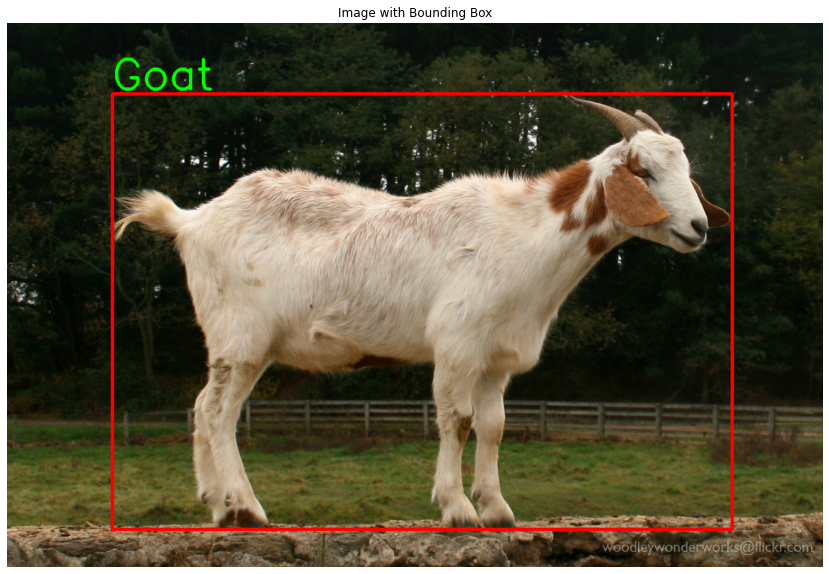

Image: (960, 1200, 3)
Coordinates: (138, 0), (1199, 958)


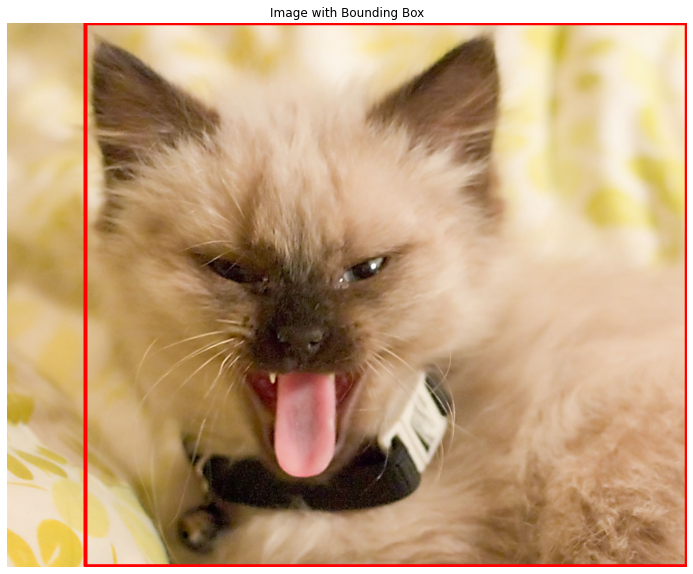

Image: (540, 720, 3)
Coordinates: (99, 50), (657, 432)


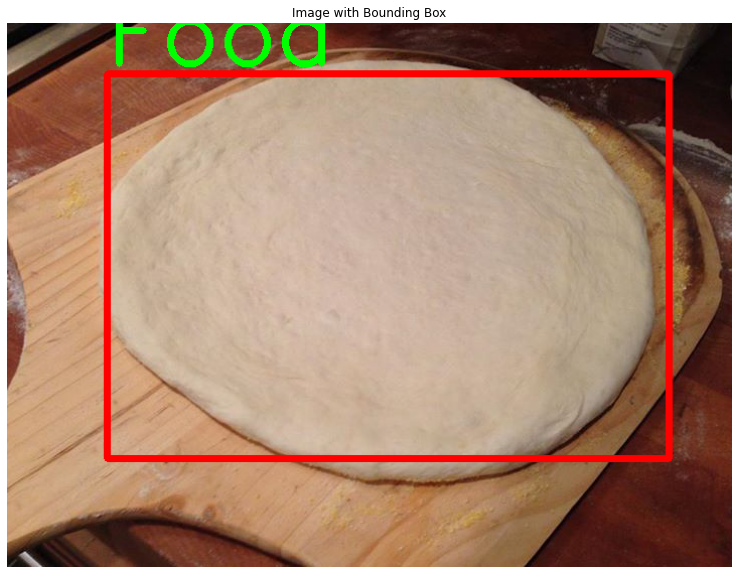

Image: (1200, 1600, 3)
Coordinates: (151, 105), (1469, 1085)


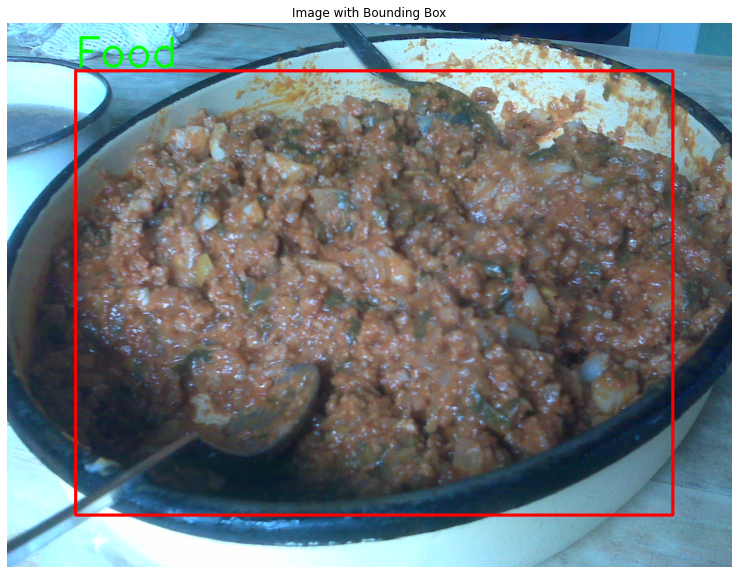

Image: (2448, 3264, 3)
Coordinates: (236, 683), (526, 1185)


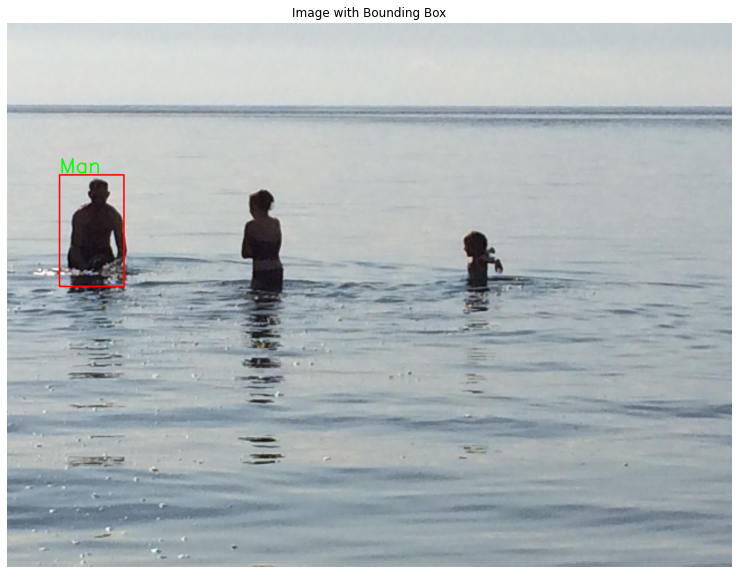

In [10]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values

for img_id in random.sample(list(least_objects_img_ids), 5):
    plot_bbox(img_id)